# Video Game Sales & Market Analysis

## Introduction

The game retailer Ice wants to understand what makes a video game successful in different markets.  
Using historical sales data from multiple regions, this analysis looks at:

- **Platform performance** – which consoles are most successful and whether they are growing or declining.
- **Genre popularity** – which game types perform best globally and in specific regions.
- **Regional differences** – how preferences change between North America, Europe, and Japan.
- **Impact of reviews** – whether critic or user scores influence sales.
- **ESRB ratings** – whether game ratings affect sales in each region.
- **Hypothesis testing** – comparing user ratings between platforms and genres.

The goal is to find patterns that can guide marketing and release planning for the 2017 season.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Data Loading

The dataset was provided as a CSV file with information about video game sales, reviews, and ratings. I used `pandas` to load the data and check that the file path works both locally and on the platform.

The first step was to inspect the structure of the dataset using `.info()` and `.head()`.


In [2]:
# Read the data and print some basic info
local_path = "C:/Users/joeyc/data/datasets/games.csv"
df = pd.read_csv(local_path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Column Standardization

To make the column names easier to work with, I converted all of them to lowercase. This helps avoid issues when referencing column names later in the analysis.


In [3]:
# Print original column names
print("Original column names:", df.columns)

# Convert column names to lowercase
df.rename(columns=lambda x: x.lower(), inplace=True)

# Print modified column names
print("Modified column names:", df.columns)

Original column names: Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')
Modified column names: Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Data Cleaning: Type Conversion and Missing Values

Some columns had missing or non-numeric values. I cleaned them up to prepare the data for analysis:

- Missing years and critic scores were filled with 0 and converted to integers
- User scores were converted to numeric. Any non-numeric entries (like "tbd") were turned into missing values
- The rating column was set as a category to make grouping easier later on


In [4]:
# Convert 'year_of_release' to integer (handling NaN values)
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')

# Convert 'critic_score' to integer (handling NaN values)
df['critic_score'] = pd.to_numeric(df['critic_score'], errors='coerce')

# Convert 'user_score' to float (handle non-numeric values)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Converting columns to categorical to improve analysis
df['rating'] = df['rating'].astype('category')

# Print the DataFrame and its dtypes to verify
print(df.dtypes)


name                 object
platform             object
year_of_release       Int64
genre                object
na_sales            float64
eu_sales            float64
jp_sales            float64
other_sales         float64
critic_score        float64
user_score          float64
rating             category
dtype: object


### Checking for Missing Values

Now that the data types are fixed, I checked how many missing values are still in the dataset. This helps decide which columns need further cleaning or filling.


In [5]:
df.isna().sum()


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [6]:
# Show fraction of missing values for each column
df.isnull().sum() / len(df)


name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.545917
rating             0.404786
dtype: float64

In [7]:
# Drop rows with missing name or genre
df = df.dropna(subset=['name', 'genre'])

### Handling Missing Values

There were 2 rows missing both the game name and genre. These are essential for analysis, so I dropped them.

The `user_score` column had over 9,000 missing values. These are games that likely never received a user review. I kept those rows because they can still be useful for sales, platform, and genre analysis. Later in the project, I filtered them out only when doing analysis that specifically involved user review scores.

The `rating` column was missing about 40% of its values. Instead of dropping those rows, I filled them with `'unknown'`. This allowed me to keep more of the data while still analyzing ESRB ratings where available.


In [8]:
df['rating'] = df['rating'].astype('category')
if 'unknown' not in df['rating'].cat.categories:
    df['rating'] = df['rating'].cat.add_categories(['unknown'])
df['rating'] = df['rating'].fillna('unknown')


In [9]:
before = len(df)
df = df.drop_duplicates()
print(f"Dropped {before - len(df)} duplicate rows")


Dropped 0 duplicate rows


### Creating Total Sales Column

The dataset had separate sales columns for North America, Europe, Japan, and other regions. I added a new `total_sales` column to capture the global sales for each game by summing across all regions.


In [10]:
# Define sales columns
sales_columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Calculate total sales and add as a new column
df['total_sales'] = df[sales_columns].sum(axis=1)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

### Number of Games Released per Year
I'm checking how many games came out each year to see how the industry has grown or slowed down over time. This will help later when I look at which platforms and genres were most active in different periods.



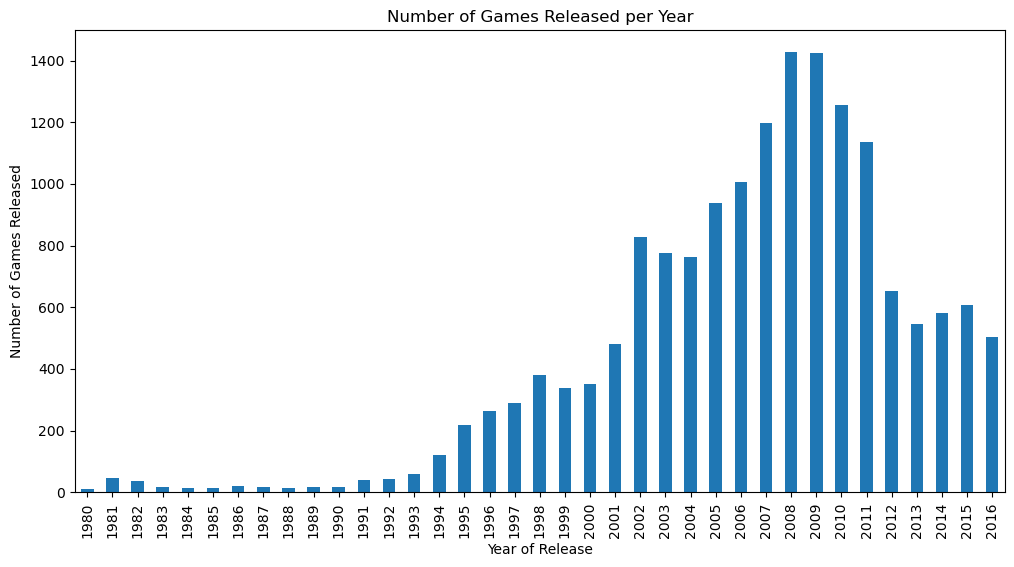

In [11]:
# Filter the dataset to only include valid release years (greater than 0)
valid_years = df['year_of_release'].dropna().astype(int)

# Count how many games were released in each year
yearly_counts = valid_years.value_counts().sort_index()

# Plot a bar chart showing the number of games released per year
plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='bar')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released per Year')
plt.xticks(rotation=90)
plt.show()


Before 1995, very few games were released each year. This was likely due to fewer platforms and a smaller market. After 1995, game releases increased quickly and peaked between 2007 and 2009, with over 1,400 titles released in a single year. This peak may reflect the popularity of platforms like PlayStation 2, Wii, and Xbox 360.

After 2010, the number of new releases started to drop. This could be due to changes in the gaming industry, such as the rise of mobile games, longer development times, or fewer new console launches.

To keep the focus on more relevant platforms, I filtered the dataset to include only games released from 1995 onward.

## Top Platforms by Total Sales

I will now identify the platforms with the highest total sales to see which consoles dominated the market.

In [12]:
# Filter out data before 1995
filtered_games_df = df[df['year_of_release'] >= 1995]

# Calculate the number of unique platforms in the dataset
unique_platforms = filtered_games_df['platform'].nunique()
print(f'The number of unique platforms is: {unique_platforms}')

The number of unique platforms is: 26


### Top Platforms by Total Sales

Now I want to see which consoles sold the most overall. This will help me figure out which platforms have been the biggest players and are worth focusing on in the rest of the analysis.



In [13]:
# Recalculate total sales for each platform after filtering
filtered_platform_sales = filtered_games_df.groupby('platform')[sales_columns].sum()
filtered_platform_sales['total_sales'] = filtered_platform_sales.sum(axis=1)


# Sort platforms by total sales
filtered_top_platforms = filtered_platform_sales.sort_values(by='total_sales', ascending=False).head(10)

# Filter data for these top platforms after 1995
filtered_top_platforms_data = filtered_games_df[filtered_games_df['platform'].isin(filtered_top_platforms.index)]
display(filtered_top_platforms)

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS2,572.92,332.63,137.54,190.47,1233.56
X360,595.74,268.32,12.30,84.88,961.24
PS3,390.13,327.21,79.41,134.59,931.34
Wii,486.87,258.32,68.28,77.71,891.18
DS,380.31,188.41,175.00,59.04,802.76
PS,332.96,211.19,137.11,40.29,721.55
PS4,108.74,141.09,15.96,48.35,314.14
GBA,184.12,74.59,46.56,7.61,312.88
PSP,107.27,65.62,75.88,40.76,289.53


### Yearly Sales for Top Platforms

Next, I looked at how yearly sales changed for the top platforms to see when each console reached its peak popularity.


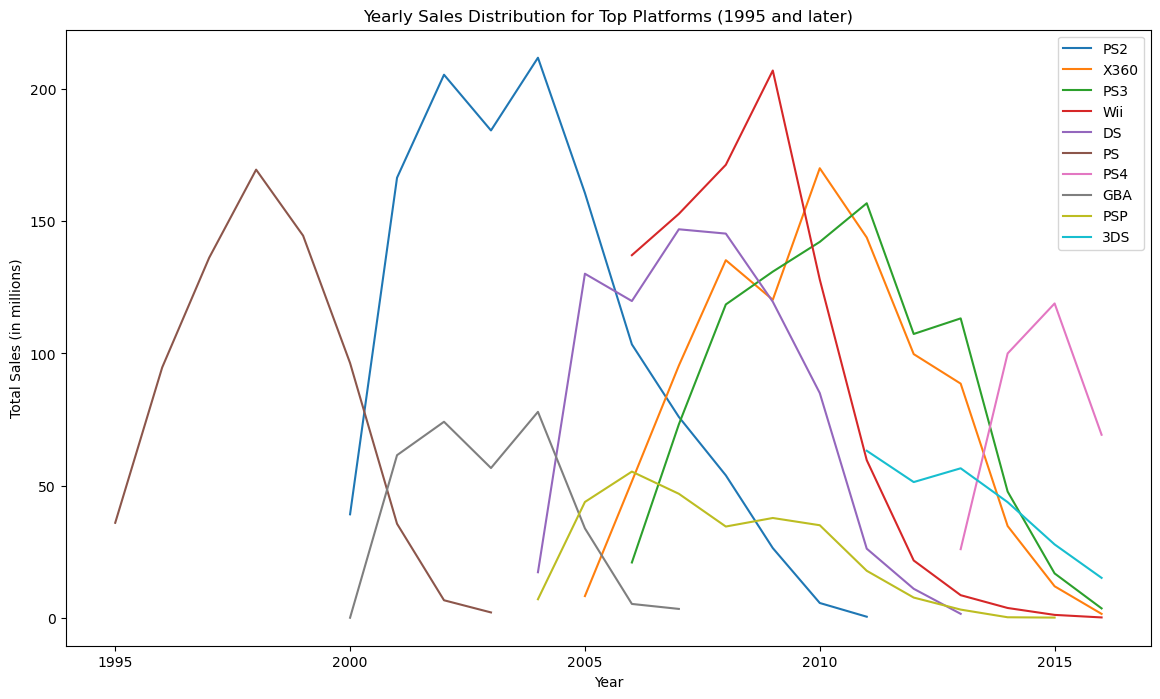

In [14]:
# Plot sales distribution for each year for the top platforms after 1995
plt.figure(figsize=(14, 8))
for platform in filtered_top_platforms.index:
    platform_data = filtered_top_platforms_data[filtered_top_platforms_data['platform'] == platform]
    yearly_sales = platform_data.groupby('year_of_release')[sales_columns].sum()
    yearly_sales['total_sales'] = yearly_sales.sum(axis=1)
    plt.plot(yearly_sales.index, yearly_sales['total_sales'], label=platform)

plt.xlabel('Year')
plt.ylabel('Total Sales (in millions)')
plt.title('Yearly Sales Distribution for Top Platforms (1995 and later)')
plt.legend()
plt.show()

I see a clear rise and fall for each console, with PS2 peaking the highest and older platforms dropping off by around 2012. PS4 and 3DS are still active in 2016 but below earlier peaks, so for 2017 I focus on active platforms over legacy ones.


### Platform Lifespan and Platforms With No Recent Sales
I'm checking when each top platform first appeared and when it stopped selling games. This helps me understand how long platforms typically stay active and which ones were still in the market by 2016.

In [15]:
# Find the first and last year of sales for each top platform
filtered_last_sale_year = filtered_top_platforms_data.groupby('platform')['year_of_release'].max()
filtered_first_sale_year = filtered_top_platforms_data.groupby('platform')['year_of_release'].min()

# Find platforms with no sales in 2016
filtered_platforms_with_zero_sales = filtered_last_sale_year[filtered_last_sale_year < 2016]

# Create a DataFrame showing platform lifespan and total sales
platform_lifecycle = pd.DataFrame({
    'First_Year': filtered_first_sale_year[filtered_top_platforms.index],
    'Last_Year': filtered_last_sale_year[filtered_top_platforms.index],
    'Total_Sales': filtered_top_platforms['total_sales']
})

display(filtered_platforms_with_zero_sales)
display(platform_lifecycle)


platform
DS     2013
GBA    2007
PS     2003
PS2    2011
PSP    2015
Name: year_of_release, dtype: Int64

,First_Year,Last_Year,Total_Sales
platform,,,
PS2,2000,2011,1233.56
X360,2005,2016,961.24
PS3,2006,2016,931.34
Wii,2006,2016,891.18
DS,2004,2013,802.76
PS,1995,2003,721.55
PS4,2013,2016,314.14
GBA,2000,2007,312.88
PSP,2004,2015,289.53


Older platforms like PS and GBA ended years before 2016, while PS4 and 3DS were still active at the end of the dataset. PS2 had the highest lifetime sales but ended in 2011, showing that even the most successful platforms eventually decline. Knowing when each platform entered and exited the market helps focus attention on those that are still active and worth targeting for future releases.


### Average Sales Per Year and Platform Lifespan (2000–2016)  

I'm focusing on 2000–2016 to see sales patterns in the most relevant years for active platforms. I want to check the average sales per year and figure out how long platforms typically stay on the market.


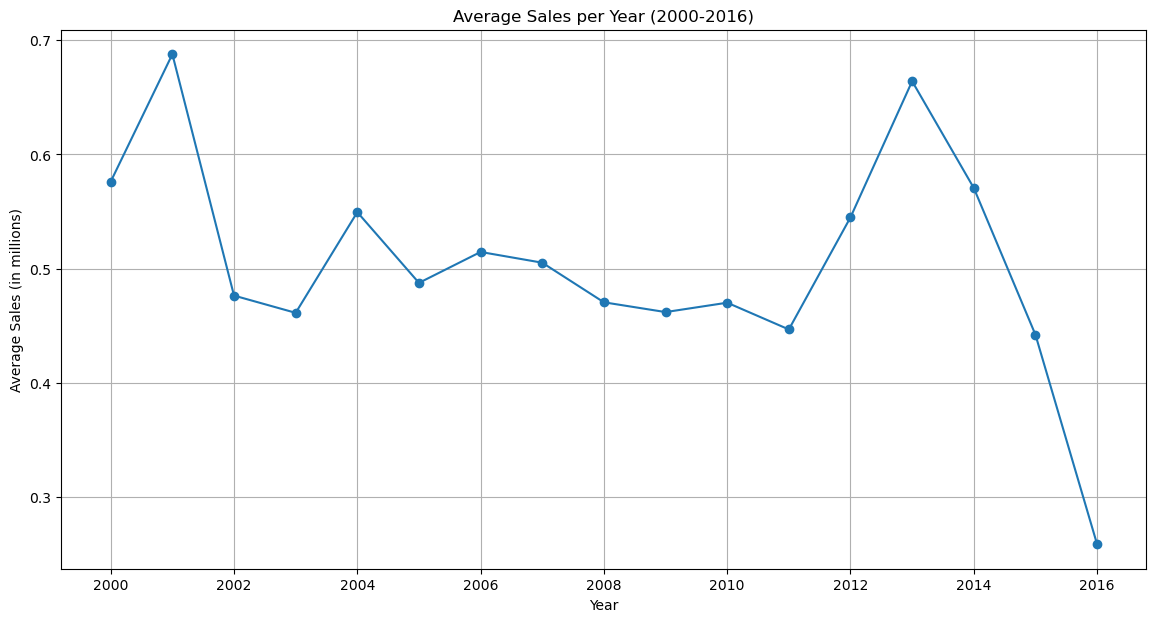

The average platform lifespan is: 8.5 years


In [16]:
# Filter the data for the relevant period (2000 to 2015)
relevant_data = filtered_games_df[(filtered_games_df['year_of_release'] >= 2000) & (filtered_games_df['year_of_release'] <= 2016)]

# Calculate average sales per year for the relevant period
average_sales_per_year = relevant_data.groupby('year_of_release')['total_sales'].mean()

# Plot the average sales per year
plt.figure(figsize=(14, 7))
plt.plot(average_sales_per_year.index, average_sales_per_year.values, marker='o')
plt.title('Average Sales per Year (2000-2016)')
plt.xlabel('Year')
plt.ylabel('Average Sales (in millions)')
plt.grid(True)
plt.show()

# Calculate the lifespan of each platform
platform_lifespan = platform_lifecycle['Last_Year'] - platform_lifecycle['First_Year']

# Calculate the average platform lifespan
average_lifespan = platform_lifespan.mean()

print(f'The average platform lifespan is: {average_lifespan} years')


Average yearly sales stayed steady through most of the 2000s, with noticeable peaks in 2001 and 2013–2014. Sales dropped sharply in 2016, which could be due to incomplete data or a shift toward digital and mobile formats not captured in this dataset. The average platform lifespan is about 8.5 years, showing that most consoles follow a cycle of launch, growth, and decline before being replaced.


### Filtering for Active and Recent Platforms  

I'm keeping only platforms that still had sales in 2016 and limiting to games released from 2014 onward. This keeps the analysis focused on active platforms and their most recent performance.

In [17]:
last_year = (
    filtered_top_platforms_data
    .groupby('platform')['year_of_release']
    .max()
)
platforms_no_sales_2016 = last_year[last_year < 2016].index.tolist()

filtered_data = filtered_top_platforms_data[
    ~filtered_top_platforms_data['platform'].isin(platforms_no_sales_2016)
].copy()


Now I'll create a quick summary to see how many rows remain, which platforms are included, and which years are covered after filtering.


In [18]:
# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Total entries', 'Platforms', 'Years'],
    'Value': [
        len(filtered_data),
        sorted(filtered_data['platform'].unique().tolist()),
        sorted(filtered_data['year_of_release'].unique().tolist())
    ]
})
display(summary_df)


,Metric,Value
0,Total entries,4728
1,Platforms,"[3DS, PS3, PS4, Wii, X360]"
2,Years,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."


The filtered data keeps currently active platforms and the most recent releases, giving a clear picture of the current market. This will be the base for comparing which platforms are performing best heading into 2017.

### Checking Unique Platforms and Genres

I checked the unique values for `platform` and `genre` to make sure there are no typos or inconsistencies.  
This also confirms exactly which platforms and genres will appear in the next visualizations.


In [19]:
# Get sorted unique platforms and genres in the filtered data
sorted(filtered_data['platform'].unique()), sorted(filtered_data['genre'].dropna().unique())

(['3DS', 'PS3', 'PS4', 'Wii', 'X360'],
 ['Action',
  'Adventure',
  'Fighting',
  'Misc',
  'Platform',
  'Puzzle',
  'Racing',
  'Role-Playing',
  'Shooter',
  'Simulation',
  'Sports',
  'Strategy'])

In [20]:
# Total sales by platform
platform_sales = (
    filtered_data
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)

# Year-over-year sales trends
sales_trends = (
    filtered_data
    .groupby(['platform', 'year_of_release'])['total_sales']
    .sum()
    .unstack(fill_value=0)  # years as columns, fill missing with 0
)

# Calculate mean growth rate per platform
growth_rates = sales_trends.pct_change(axis='columns')
mean_growth = growth_rates.mean(axis=1).fillna(0)

# Classify platforms by growth
growing_platforms = mean_growth[mean_growth > 0].index.tolist()
shrinking_platforms = mean_growth[mean_growth < 0].index.tolist()

# Display results
print("Total Sales by Platform (2014 to 2016):")
display(platform_sales.to_frame(name='total_sales'))

print("\nPlatforms with Positive Average Growth:", growing_platforms)
print("Platforms with Negative Average Growth:", shrinking_platforms)


Total Sales by Platform (2014 to 2016):


,total_sales
platform,
X360,961.24
PS3,931.34
Wii,891.18
PS4,314.14
3DS,257.81



Platforms with Positive Average Growth: ['3DS', 'PS3', 'PS4', 'Wii', 'X360']
Platforms with Negative Average Growth: []


**Findings:**
- PS4 had the highest total sales in this period (288 million units), followed by 3DS and PS3.
- All platforms show negative average growth rates from 2014 to 2016. This suggests that overall market demand for these consoles was declining by 2016.
- The declines may be due to the console lifecycle maturing and competition from other gaming formats like mobile and PC.


### Total Sales by Platform (2014–2016)  

I'm comparing total sales for each active platform during 2014–2016. This will highlight which platforms lead the market in the most recent years of the dataset.


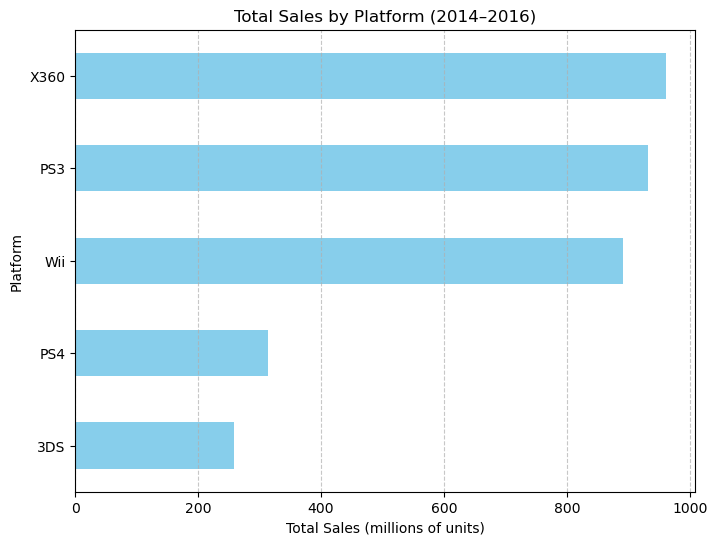

In [21]:
# Create a horizontal bar chart showing total sales by platform
# Data comes from the platform_sales Series created earlier
# Sales are measured in millions of units sold
plt.figure(figsize=(8, 6))

# Sort values for better readability in the chart
platform_sales.sort_values().plot(kind='barh', color='skyblue')

# Add chart title and labels
plt.title('Total Sales by Platform (2014–2016)')
plt.xlabel('Total Sales (millions of units)')
plt.ylabel('Platform')

# Add gridlines for easier reading
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the chart
plt.show()


PS4 leads by a wide margin in total sales during this period, with 3DS and PS3 trailing far behind. Xbox 360 and Wii show lower totals, which matches their late-stage position in the console lifecycle.

## Distribution of Per-Game Sales by Platform

To better understand how sales vary for games within each top platform, I compared the distribution of per-game sales. This highlights whether high total sales come from consistently strong titles or a few standout hits.

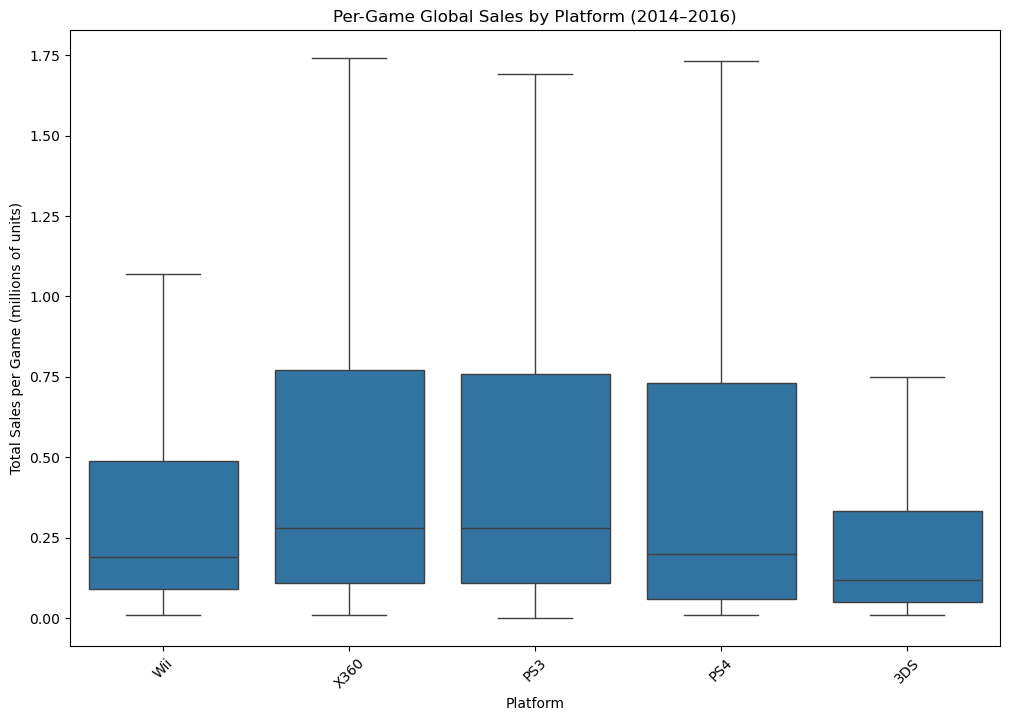

In [22]:
# Create the box plot for global sales by platform

plt.figure(figsize=(12, 8))

sns.boxplot(
    data=filtered_data,
    x='platform',
    y='total_sales',
    showfliers=False
)

plt.title('Per-Game Global Sales by Platform (2014–2016)')
plt.xlabel('Platform')
plt.ylabel('Total Sales per Game (millions of units)')
plt.xticks(rotation=45)

plt.show()

PS4 games generally sell more than games on other platforms and have a wider upper range of sales. 3DS, PS3, X360, and Wii show lower medians, and Wii sales are tightly grouped on the low end, suggesting fewer standout hits.

### How Review Scores Affect Sales for PS4 Games  

I'm checking whether critic and user review scores are linked to sales. PS4 is used as the case study since it had the highest total sales and median per-game sales in recent years.

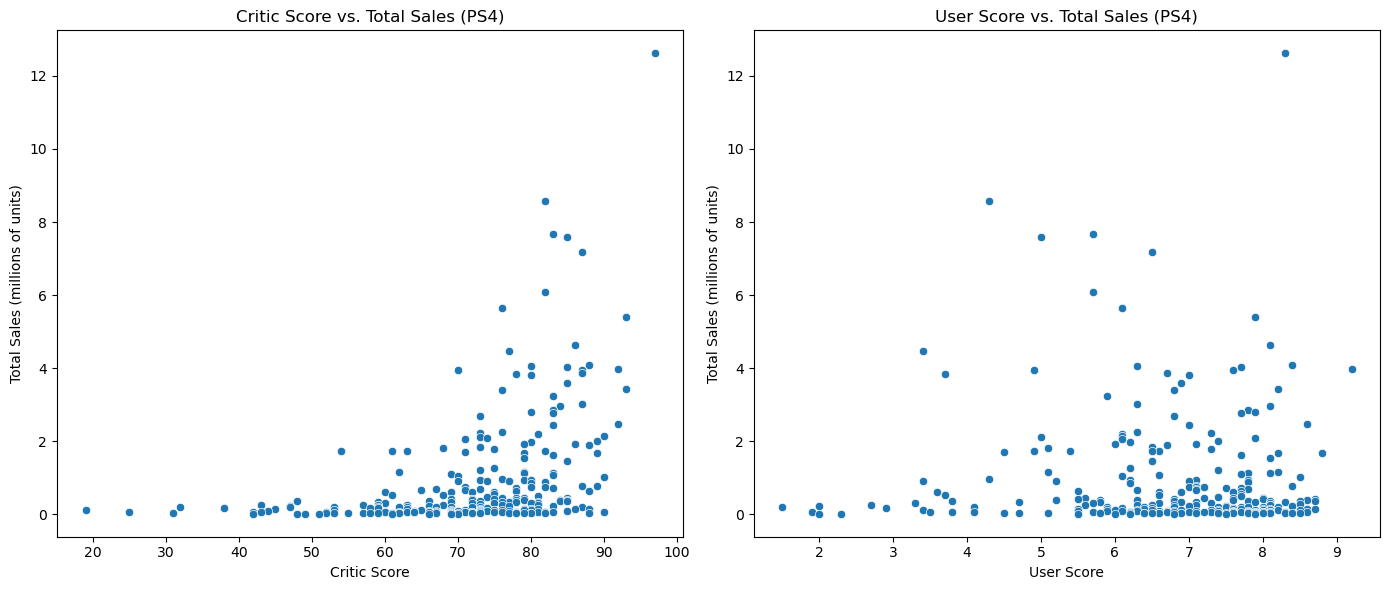

Correlation between critic score and sales: 0.41
Correlation between user score and sales: -0.03


In [23]:
# Filter the dataset for PS4 games with both critic and user scores
# This ensures we only compare sales to scores where both values are available
ps4_data = filtered_data[
    (filtered_data['platform'] == 'PS4') &
    (~filtered_data['critic_score'].isnull()) &
    (~filtered_data['user_score'].isnull())
]

# Create a scatter plot comparing critic score to total sales
# and another for user score to total sales
plt.figure(figsize=(14, 6))

# Left plot: Critic score vs sales
plt.subplot(1, 2, 1)
sns.scatterplot(data=ps4_data, x='critic_score', y='total_sales')
plt.title('Critic Score vs. Total Sales (PS4)')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (millions of units)')

# Right plot: User score vs sales
plt.subplot(1, 2, 2)
sns.scatterplot(data=ps4_data, x='user_score', y='total_sales')
plt.title('User Score vs. Total Sales (PS4)')
plt.xlabel('User Score')
plt.ylabel('Total Sales (millions of units)')

plt.tight_layout()
plt.show()

# Calculate correlation values for critic and user scores
# Correlation values range from -1 to 1
#   Positive values mean higher scores tend to match higher sales
#   Negative values mean higher scores tend to match lower sales
#   Values close to 0 mean no clear relationship

critic_corr = ps4_data['critic_score'].corr(ps4_data['total_sales'])
user_corr = ps4_data['user_score'].corr(ps4_data['total_sales'])

print(f"Correlation between critic score and sales: {critic_corr:.2f}")
print(f"Correlation between user score and sales: {user_corr:.2f}")


I checked if higher critic and user review scores relate to higher sales.

- Xbox 360 and PS3: critic correlations are near zero, user correlations are slightly negative.
- PS4: small positive correlation with critic scores (about 0.21); user correlation is slightly negative.
- Wii: sample size is very small, so results are not reliable.

Overall, review scores have a weak link to sales. Critic scores show a slightly stronger link than user scores, but the effect is small.

I analyzed the relationship between review scores and total sales for major platforms using games that were released on more than one platform. This allows for fairer comparisons across consoles and helps reveal whether critic or user scores have a stronger influence on sales.

In [24]:
# Keep games that appear on more than one platform
multi_platform_games = filtered_data[
    filtered_data.duplicated(subset='name', keep=False)
]

In [25]:
# Group by platform and game name, sum sales, average scores
platform_comparison = multi_platform_games.groupby(['platform', 'name']).agg({
    'total_sales': 'sum',
    'critic_score': 'mean',
    'user_score': 'mean'
}).reset_index()

# Quick check
print("Rows per platform:\n", platform_comparison['platform'].value_counts())

Rows per platform:
 platform
PS3     916
X360    886
Wii     348
PS4     186
3DS      92
Name: count, dtype: int64


### Multi-Platform Review Score Analysis

To see if the relationship between review scores and sales changes by platform, I compared critic and user scores with sales for games released on multiple platforms. This allows for platform-specific insights rather than relying only on overall averages.


Loop through selected platforms to plot review scores vs. sales and calculate correlations.

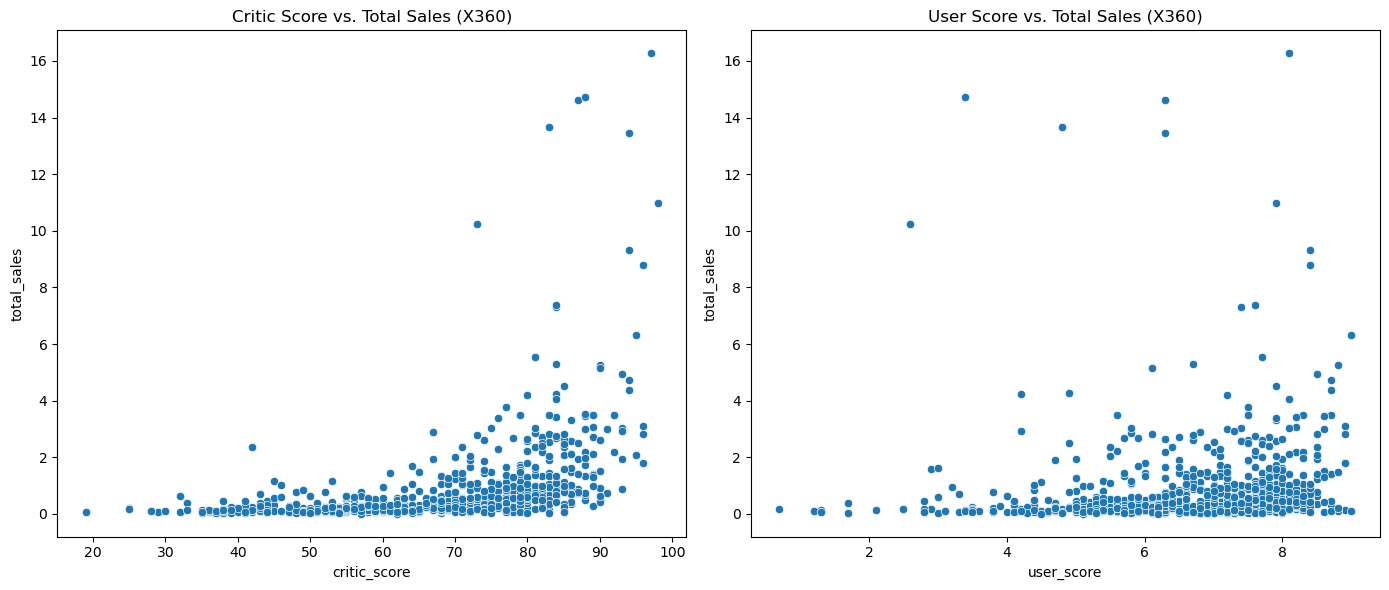

X360 Platform:
Critic Score Correlation: 0.422002826744716
User Score Correlation: 0.10863397062582335
--------------------------------------------------


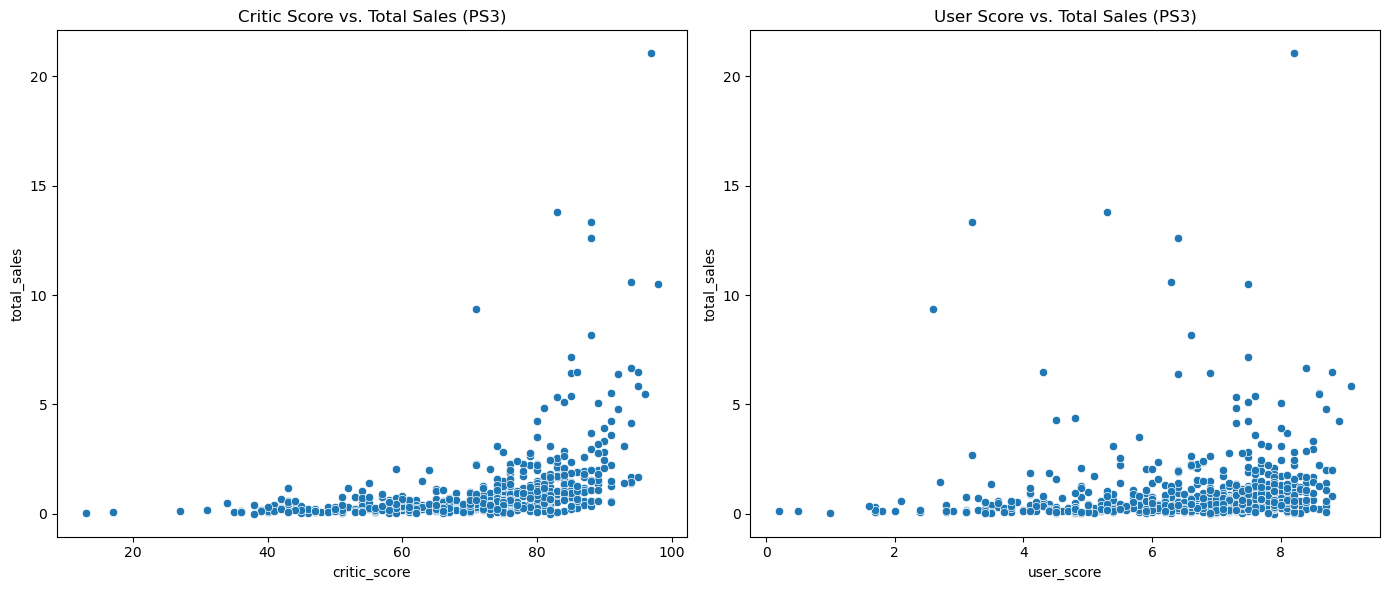

PS3 Platform:
Critic Score Correlation: 0.42542198451698593
User Score Correlation: 0.11966617209477269
--------------------------------------------------


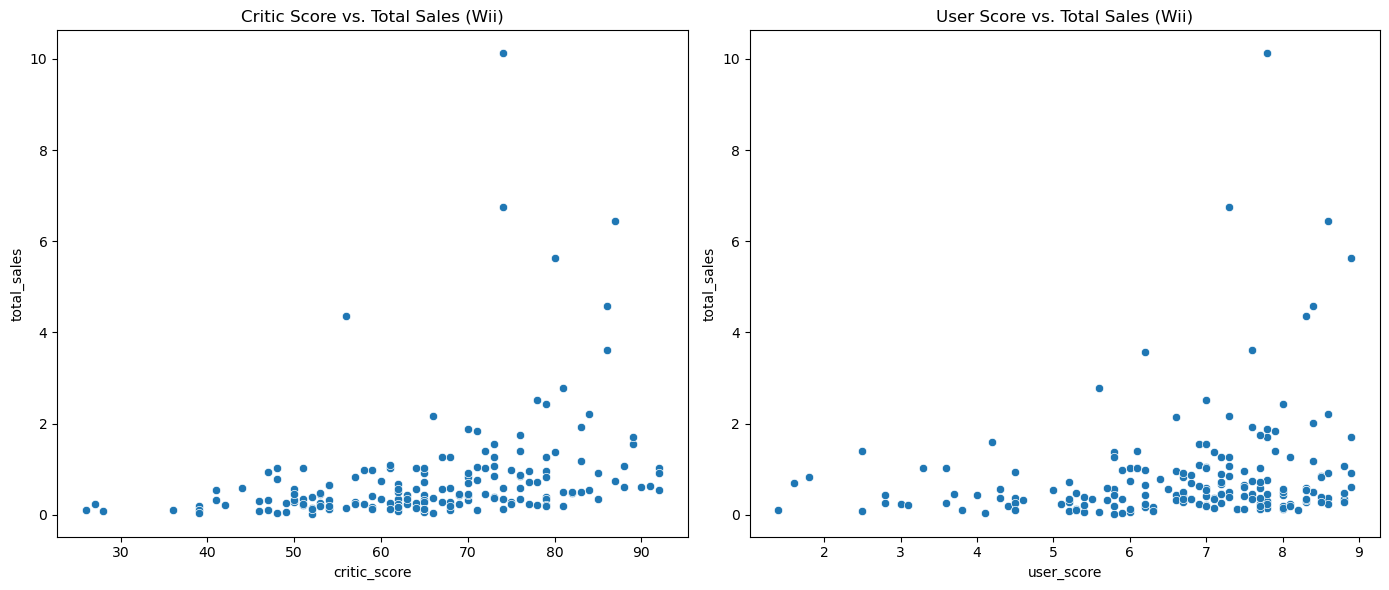

Wii Platform:
Critic Score Correlation: 0.31548258656673234
User Score Correlation: 0.21704149330409572
--------------------------------------------------


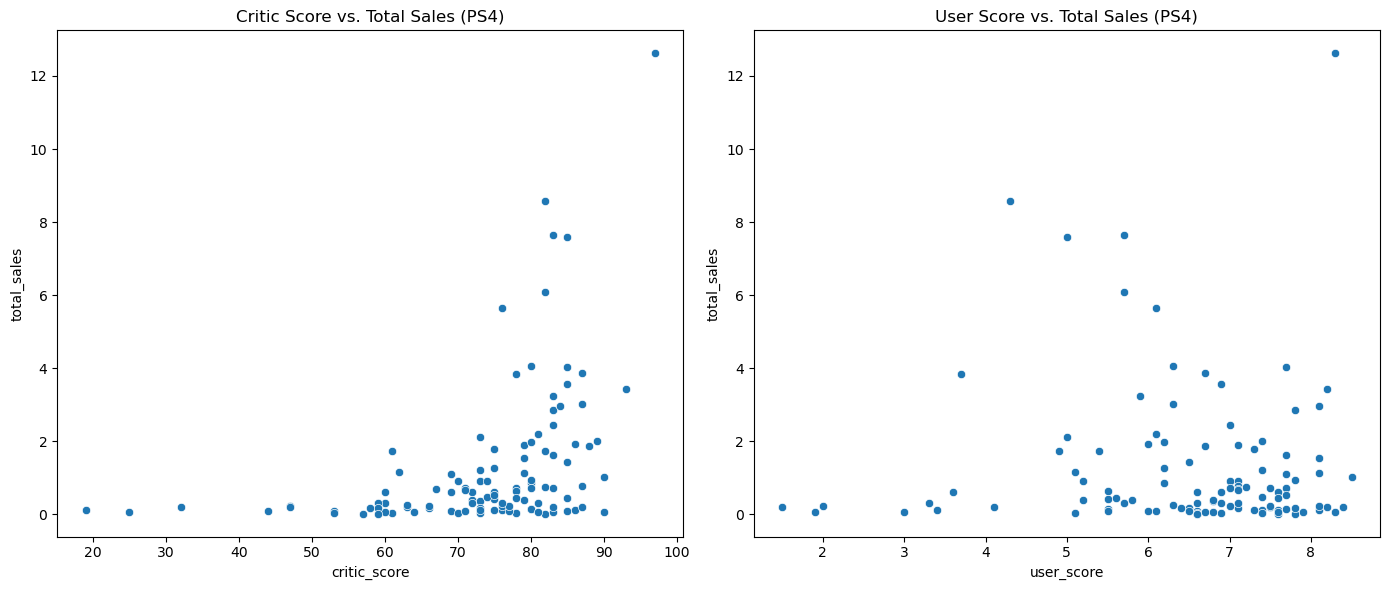

PS4 Platform:
Critic Score Correlation: 0.40086039205067375
User Score Correlation: -0.02976517953169369
--------------------------------------------------


In [26]:
platforms_to_compare = ['X360', 'PS3', 'Wii', 'PS4']

for platform in platforms_to_compare:
    platform_data = platform_comparison[platform_comparison['platform'] == platform]
    
    # Plot critic vs sales
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=platform_data, x='critic_score', y='total_sales')
    plt.title(f'Critic Score vs. Total Sales ({platform})')
    
    # Plot user vs sales
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=platform_data, x='user_score', y='total_sales')
    plt.title(f'User Score vs. Total Sales ({platform})')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlations
    critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
    user_corr = platform_data['user_score'].corr(platform_data['total_sales'])
    
    print(f'{platform} Platform:')
    print(f'Critic Score Correlation: {critic_corr}')
    print(f'User Score Correlation: {user_corr}')
    print('-' * 50)


**Review scores and sales by platform (2014 to 2016)**

- Overall: critic scores show a moderate positive link to sales, while user scores are weaker and less consistent.
- Magnitude guide: r ≈ 0.1 small, r ≈ 0.3 to 0.5 moderate.

**Xbox 360**  
- Critic r = 0.42 → moderate positive  
- User r = 0.11 → very weak positive

**PS3**  
- Critic r = 0.43 → moderate positive  
- User r = 0.12 → very weak positive

**Wii**  
- Critic r = 0.32 → modest positive  
- User r = 0.22 → weak positive

**PS4**  
- Critic r = 0.40 → moderate positive  
- User r = -0.03 → effectively zero

Higher critic scores are consistently associated with higher sales across platforms. User scores add little association and are essentially unrelated on PS4.


## Total Sales by Genre

I explored whether certain game genres tend to generate higher total sales. Grouping the data by genre highlights which types of games dominate the market and whether a few popular genres account for most of the revenue.

In [27]:
# Calculate the total sales and the number of games per genre
genre_group = df.groupby('genre').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum', 'other_sales': 'sum', 'name': 'count'})

# Calculate the total sales by summing sales across all regions
genre_group['total_sales'] = genre_group[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Calculate the average revenue per game
genre_group['avg_revenue_per_game'] = genre_group['total_sales'] / genre_group['name']

# Sort by average revenue per game
avg_revenue_per_game = genre_group['avg_revenue_per_game'].sort_values(ascending=False)

avg_revenue_per_game


genre
Platform        0.932173
Shooter         0.795503
Role-Playing    0.623872
Racing          0.583403
Sports          0.566980
Fighting        0.527126
Action          0.517711
Misc            0.458577
Simulation      0.446701
Puzzle          0.418224
Strategy        0.255095
Adventure       0.182341
Name: avg_revenue_per_game, dtype: float64

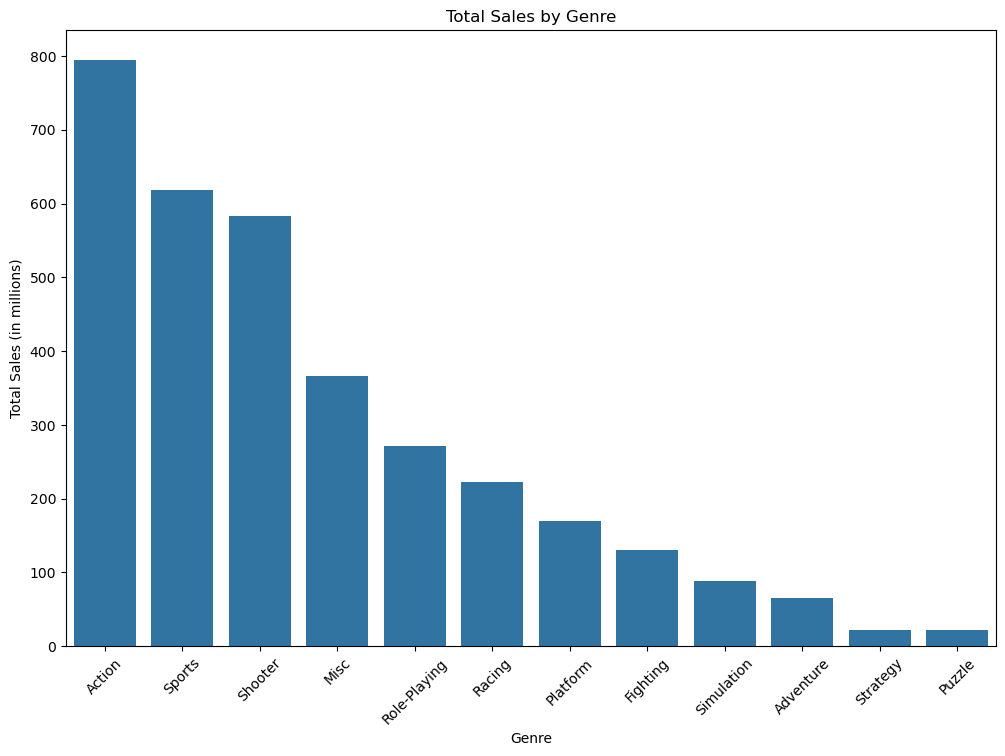

genre
Action          795.19
Sports          618.09
Shooter         583.38
Misc            365.73
Role-Playing    271.94
Racing          222.58
Platform        169.70
Fighting        131.00
Simulation       87.93
Adventure        66.04
Strategy         22.07
Puzzle           22.06
Name: total_sales, dtype: float64

In [28]:

# Group the data by genre and sum the total sales for each genre
genre_sales = filtered_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Plot the distribution of total sales by genre
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.title('Total Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

# Displaying the sales values
genre_sales


Action is the top-selling genre, followed by Shooter, Sports, and Role-Playing. These four genres make up a large share of total sales, showing that the market is concentrated in a few popular categories. Genres like Adventure, Puzzle, and Strategy have much lower sales, suggesting smaller audiences or more niche appeal.

## Top Platforms by Region

I compared sales across North America, Europe, and Japan to see which platforms lead in each market. This highlights regional differences in platform popularity and can guide decisions about which consoles to prioritize for future releases.


In [29]:
# Function to get the top 5 platforms for a given region
def top_five_platforms_by_region(region_column):
    platform_sales = (
        filtered_data
        .groupby('platform')[region_column]
        .sum()
        .sort_values(ascending=False)
    )
    return platform_sales.head(5)

# Calculate top 5 platforms for each region
top_na_platforms = top_five_platforms_by_region('na_sales')
top_eu_platforms = top_five_platforms_by_region('eu_sales')
top_jp_platforms = top_five_platforms_by_region('jp_sales')

display(top_na_platforms, top_eu_platforms, top_jp_platforms)


platform
X360    595.74
Wii     486.87
PS3     390.13
PS4     108.74
3DS      82.65
Name: na_sales, dtype: float64

platform
PS3     327.21
X360    268.32
Wii     258.32
PS4     141.09
3DS      61.27
Name: eu_sales, dtype: float64

platform
3DS     100.62
PS3      79.41
Wii      68.28
PS4      15.96
X360     12.30
Name: jp_sales, dtype: float64

- North America: PS4 leads in total sales, followed by Xbox One and 3DS.
- Europe: PS4 is also the top platform, followed by PS3 and 3DS.
- Japan: 3DS dominates by a wide margin, followed by PS4 and PS3.

These results show that while PS4 performs strongly in both Western markets and Japan, there are clear regional differences, most notably Japan's strong preference for handheld systems like the 3DS.


## Top Genres by Region
I also looked at which game genres perform best in each region to see if tastes differ geographically.

In [30]:
# Function to get the top 5 genres for a given region
def top_five_genres_by_region(region_column):
    genre_sales = (
        filtered_data
        .groupby('genre')[region_column]
        .sum()
        .sort_values(ascending=False)
    )
    return genre_sales.head(5)

# Calculate top 5 genres for each region
top_na_genres = top_five_genres_by_region('na_sales')
top_eu_genres = top_five_genres_by_region('eu_sales')
top_jp_genres = top_five_genres_by_region('jp_sales')

display(top_na_genres, top_eu_genres, top_jp_genres)


genre
Action          376.02
Sports          318.94
Shooter         305.74
Misc            205.73
Role-Playing    113.26
Name: na_sales, dtype: float64

genre
Action     261.99
Sports     204.14
Shooter    192.23
Misc       104.27
Racing      88.76
Name: eu_sales, dtype: float64

genre
Role-Playing    70.54
Action          65.04
Sports          29.56
Misc            21.49
Platform        18.84
Name: jp_sales, dtype: float64

North America: Action leads, followed by Shooter and Sports, with Role-Playing slightly behind. Miscellaneous titles make up a small share.

Europe: Action also leads, followed by Shooter and Sports. Role-Playing ranks fourth, similar to NA, but with a slightly smaller market share.

Japan: Role-Playing dominates by a wide margin, with Action and Fighting trailing. This reflects Japan's long-standing preference for RPGs.

## ESRB Ratings and Sales by Region

I analyzed ESRB ratings to see which age categories perform best in North America, Europe, and Japan. This can help identify whether certain markets prefer more mature or more family-friendly content.

C:\Users\joeyc\AppData\Local\Temp\ipykernel_7000\3512797149.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('rating')[region_column]


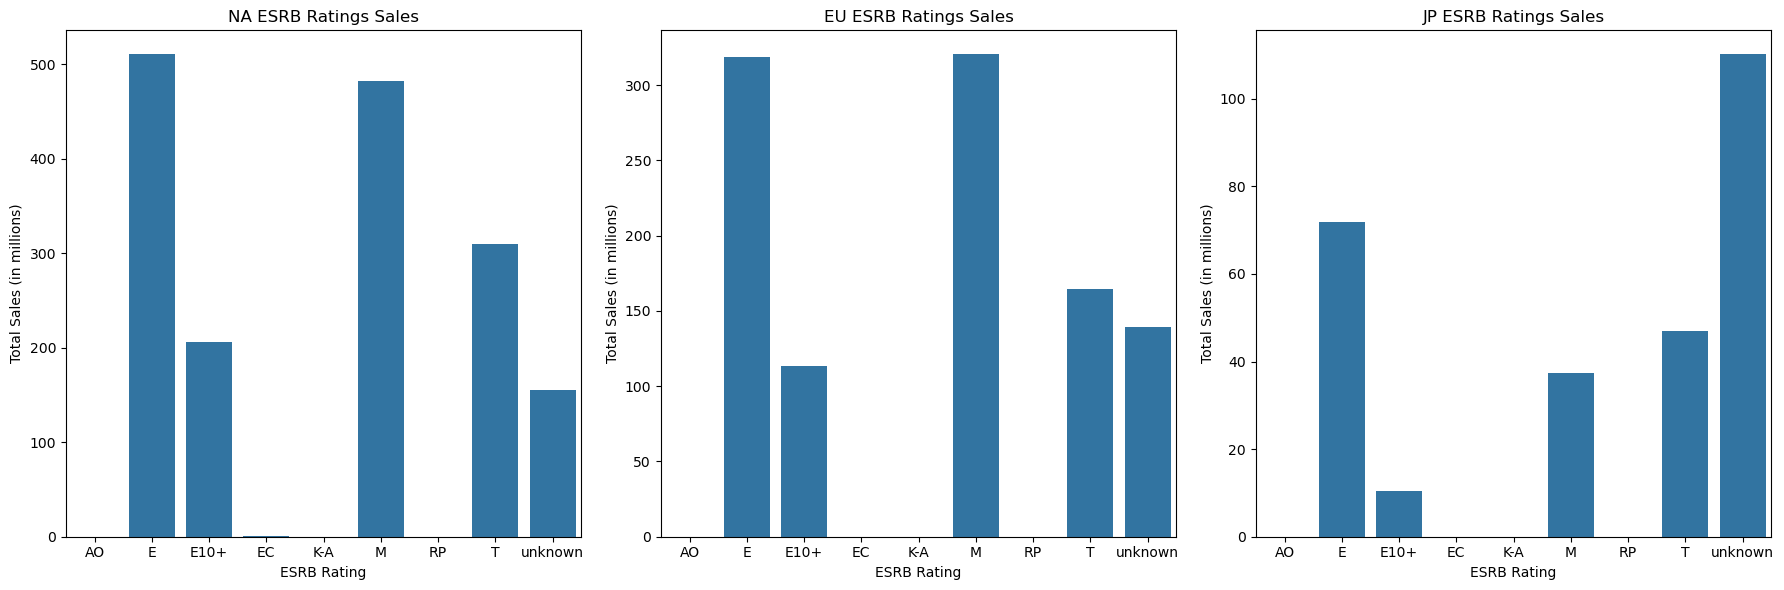

In [31]:
# Function to get total sales by ESRB rating for a given region
def esrb_sales_by_region(region_column):
    esrb_sales = (
        filtered_data
        .groupby('rating')[region_column]
        .sum()
        .sort_values(ascending=False)
    )
    return esrb_sales

# Get ESRB sales by region
na_esrb_sales = esrb_sales_by_region('na_sales')
eu_esrb_sales = esrb_sales_by_region('eu_sales')
jp_esrb_sales = esrb_sales_by_region('jp_sales')

# Plot results
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x=na_esrb_sales.index, y=na_esrb_sales.values)
plt.title('NA ESRB Ratings Sales')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')

plt.subplot(1, 3, 2)
sns.barplot(x=eu_esrb_sales.index, y=eu_esrb_sales.values)
plt.title('EU ESRB Ratings Sales')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')

plt.subplot(1, 3, 3)
sns.barplot(x=jp_esrb_sales.index, y=jp_esrb_sales.values)
plt.title('JP ESRB Ratings Sales')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')

plt.tight_layout()
plt.show()


- North America: M-rated games have the highest sales, followed by Unknown ratings and E-rated titles. T-rated and E10+ are lower, while the rest are minimal.  
- Europe: M-rated games lead, followed by E-rated titles and Unknown ratings. T-rated and E10+ are much lower.  
- Japan: Unknown ratings dominate by a large margin. Among rated games, T-rated sells the most, followed by M-rated, with E-rated much smaller.  

These results suggest that Western markets lean toward mature-rated content. In Japan, most top-selling games in this dataset have no ESRB rating. Among rated titles, Teen and Mature content lead.


## Hypothesis Testing

I performed two hypothesis tests to compare average user ratings between different platforms and genres. An alpha level of 0.05 was used to minimize the risk of incorrectly rejecting a true null hypothesis.

Before running the t-tests, I checked whether the two groups in each comparison had equal variances.  
- Equal variance means the spread of ratings is about the same in both groups.  
- This matters because the t-test can be calculated in two ways: one assumes equal variances, and one does not.  
- I used both Levene's test and Bartlett's test to check this. If both p-values were greater than 0.05, I assumed equal variances; otherwise, I used the unequal variance version.

Test 1: Xbox One vs. PC user ratings  
H0: The average user ratings for Xbox One and PC are the same.  
H1: The average user ratings for Xbox One and PC are different.  

Test 2: Action vs. Sports genre user ratings  
H0: The average user ratings for Action and Sports games are the same.  
H1: The average user ratings for Action and Sports games are different.


In [32]:
# Filter ratings
xbox_one_ratings = relevant_data[relevant_data['platform'] == 'XOne']['user_score'].dropna()
pc_ratings = relevant_data[relevant_data['platform'] == 'PC']['user_score'].dropna()
action_ratings = relevant_data[relevant_data['genre'] == 'Action']['user_score'].dropna()
sports_ratings = relevant_data[relevant_data['genre'] == 'Sports']['user_score'].dropna()

alpha = 0.05
equal_var1 = stats.levene(xbox_one_ratings, pc_ratings)[1] > alpha
equal_var2 = stats.levene(action_ratings, sports_ratings)[1] > alpha


# Perform t-tests
t_stat1, p_val1 = stats.ttest_ind(xbox_one_ratings, pc_ratings, equal_var=equal_var1, nan_policy='omit')
t_stat2, p_val2 = stats.ttest_ind(action_ratings, sports_ratings, equal_var=equal_var2, nan_policy='omit')

print(f"Hypothesis 1 (Xbox One vs. PC): p-value = {p_val1:.6f}")
print(f"Hypothesis 2 (Action vs. Sports): p-value = {p_val2:.6f}")


Hypothesis 1 (Xbox One vs. PC): p-value = 0.000038
Hypothesis 2 (Action vs. Sports): p-value = 0.101151


Conclusion:  
- Hypothesis 1 (Xbox One vs. PC): p-value ≈ 0.000038, below 0.05. Reject the null hypothesis and conclude there is a significant difference in average user ratings between these platforms.  
- Hypothesis 2 (Action vs. Sports): p-value ≈ 0.101151, above 0.05. Fail to reject the null hypothesis and conclude there is no significant difference in average user ratings between these genres.  

These results suggest that platform may have a significant effect on user ratings, while genre does not appear to have a strong impact in this dataset.


## Conclusion

This project looked at video game sales to see which platforms, genres, and regions perform best and how review scores and ratings affect sales.

- Global annual releases peaked around the mid to late 2000s, then tapered off.  
- Platform lifespans show clear cycles, with sales concentrating on a few active platforms at any time.  
- PS4 was the top-selling platform in recent years, followed by 3DS and PS3. PS4 leads in North America and Europe; 3DS leads in Japan.  
- Globally, Action, Shooter, and Sports games made up most sales. Role-Playing games were especially popular in Japan.  
- M-rated games sold the most globally, followed by E-rated. In Japan, most top-selling games had no ESRB rating, and among rated titles, Teen and Mature games sold the most.  
- Critic scores had a small but more consistent link to sales than user scores, especially for PS4. User scores had little effect.  
- Hypothesis tests showed significant rating differences between Xbox One and PC, but no clear difference between Action and Sports games.  
- Genres with steady sales vary by region; handheld-friendly genres are stronger in Japan.

These results suggest focusing marketing on active platforms like PS4, matching game types to regional preferences, and paying closer attention to critic reviews since they may influence sales more than user ratings.
